<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week01/Week01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries and Load Data



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import time
import pickle
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Display settings for better visualization
%matplotlib inline
plt.style.use('ggplot')

### Load the MNIST Dataset
We'll use scikit-learn's fetch_openml function to download the MNIST dataset.

Loading MNIST dataset...
Dataset loaded: 70000 samples with 784 features
Target labels: [0 1 2 3 4 5 6 7 8 9]


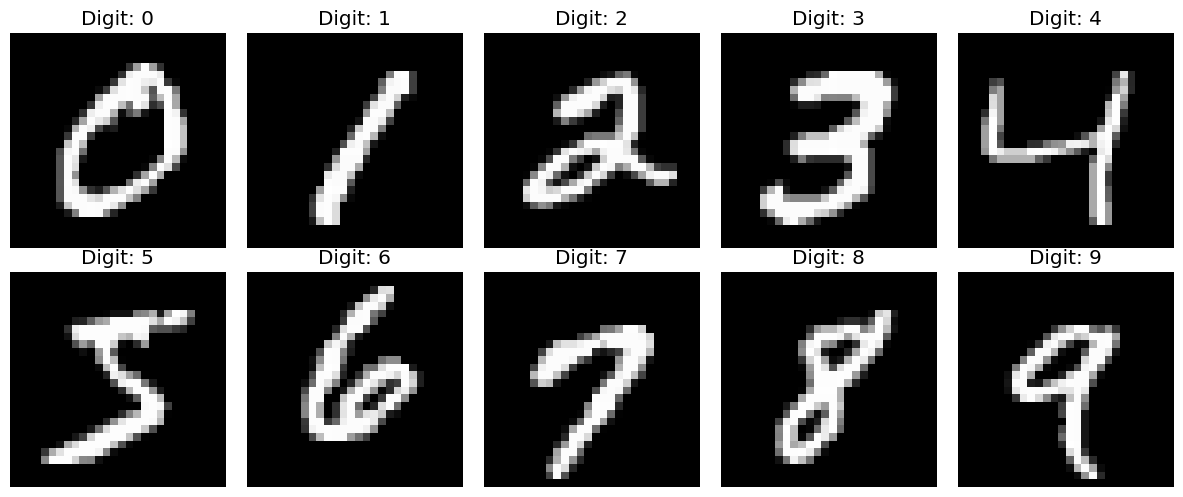

In [ ]:
# Load data from OpenML
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = np.array(X)
y = np.array(y, dtype=int)

print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features")
print(f"Target labels: {np.unique(y)}")

# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.where(y == i)[0][0]  # First occurrence of digit i
    axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Digit: {y[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing
Now we'll preprocess the data by:
1. Normalizing pixel values to [0, 1]
2. Creating one-hot encoded labels
3. Splitting data into training and testing sets

In [ ]:
def one_hot_encode(y, num_classes=10):
    """Convert labels to one-hot encoded vectors"""
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Normalize pixel values
X = X / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create one-hot encoded labels
y_train_onehot = one_hot_encode(y_train)
y_test_onehot = one_hot_encode(y_test)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test_onehot.shape}")

Training data shape: (56000, 784)
Training labels shape: (56000, 10)
Testing data shape: (14000, 784)
Testing labels shape: (14000, 10)


## 3. Neural Network Implementation
We'll now implement our neural network class from scratch. Our architecture will consist of:
- Input layer: 784 neurons (28×28 pixels)
- Hidden layer: Configurable number of neurons
- Output layer: 10 neurons (one for each digit)

In [ ]:
class DeepNeuralNetwork:
    def __init__(self, input_size=784, hidden_size=128, output_size=10,
                 activation='relu', learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.initialize_parameters()

        # Store metrics during training
        self.loss_history = []
        self.accuracy_history = []

    def initialize_parameters(self):
        """Initialize weights and biases with Xavier/He initialization"""
        if self.activation == 'relu':
            # He initialization for ReLU
            scale = np.sqrt(2 / self.input_size)
        else:
            # Xavier initialization for Sigmoid/Tanh
            scale = np.sqrt(1 / self.input_size)

        self.W1 = np.random.randn(self.input_size, self.hidden_size) * scale
        self.b1 = np.zeros((1, self.hidden_size))

        scale = np.sqrt(1 / self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * scale
        self.b2 = np.zeros((1, self.output_size))

        self.parameters = {
            'W1': self.W1, 'b1': self.b1,
            'W2': self.W2, 'b2': self.b2
        }

## 4. Activation Functions
Next, we'll implement various activation functions and their derivatives:
- ReLU: max(0, x)
- Sigmoid: 1/(1 + e^(-x))

In [ ]:
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU function"""
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    """Sigmoid activation function"""
    # Clip to avoid overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid function"""
    s = sigmoid(x)
    return s * (1 - s)


def softmax(x):
    """Softmax activation function"""
    # Shift x for numerical stability
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(shifted_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [ ]:
# Add these functions to our Neural Network class
def activate(self, x, activation=None):
    """Apply the specified activation function"""
    activation = activation or self.activation

    if activation == 'relu':
        return relu(x)
    elif activation == 'sigmoid':
        return sigmoid(x)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")

def activate_derivative(self, x, activation=None):
    """Apply the derivative of the specified activation function"""
    activation = activation or self.activation

    if activation == 'relu':
        return relu_derivative(x)
    elif activation == 'sigmoid':
        return sigmoid_derivative(x)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")

# Add these methods to our Neural Network class
DeepNeuralNetwork.activate = activate
DeepNeuralNetwork.activate_derivative = activate_derivative

## 5. Loss Function


In [ ]:
def cross_entropy_loss(y_pred, y_true):

    # Add small epsilon to prevent log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculate cross-entropy loss
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / m
    return loss

def cross_entropy_derivative(y_pred, y_true):
    m = y_true.shape[0]
    return (y_pred - y_true) / m

## 6. Model Training
Now we'll implement forward propagation, backward propagation, and the training function with mini-batch processing.

In [ ]:
def forward_pass(self, X):
    # First layer
    Z1 = np.dot(X, self.W1) + self.b1
    A1 = self.activate(Z1)

    # Output layer
    Z2 = np.dot(A1, self.W2) + self.b2
    A2 = softmax(Z2)

    # Store values for backpropagation
    cache = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2
    }

    return cache

def backward_pass(self, X, y, cache):
    m = X.shape[0]

    # Output layer gradients
    dZ2 = cross_entropy_derivative(cache['A2'], y)
    dW2 = np.dot(cache['A1'].T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    # Hidden layer gradients
    dA1 = np.dot(dZ2, self.W2.T)
    dZ1 = dA1 * self.activate_derivative(cache['Z1'])
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2
    }

    return gradients

def update_parameters(self, gradients):
    self.W1 -= self.learning_rate * gradients['dW1']
    self.b1 -= self.learning_rate * gradients['db1']
    self.W2 -= self.learning_rate * gradients['dW2']
    self.b2 -= self.learning_rate * gradients['db2']

def predict(self, X):
    cache = self.forward_pass(X)
    probabilities = cache['A2']
    predictions = np.argmax(probabilities, axis=1)
    return predictions, probabilities

def compute_accuracy(self, X, y):
    predictions, _ = self.predict(X)
    if y.ndim > 1:  # If one-hot encoded
        y = np.argmax(y, axis=1)
    return np.mean(predictions == y)

# Add methods to our Neural Network class
DeepNeuralNetwork.forward_pass = forward_pass
DeepNeuralNetwork.backward_pass = backward_pass
DeepNeuralNetwork.update_parameters = update_parameters
DeepNeuralNetwork.predict = predict
DeepNeuralNetwork.compute_accuracy = compute_accuracy

In [ ]:
def train(self, X, y, X_val=None, y_val=None, batch_size=32, epochs=10, verbose=True):
    self.loss_history = []
    self.train_accuracy_history = []
    self.val_accuracy_history = []

    n_samples = X.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))

    for epoch in range(epochs):
        start_time = time.time()

        # Shuffle the data at each epoch
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        epoch_loss = 0

        for i in range(n_batches):
            # Get mini-batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward pass
            cache = self.forward_pass(X_batch)

            # Compute loss
            batch_loss = cross_entropy_loss(cache['A2'], y_batch)
            epoch_loss += batch_loss * (end_idx - start_idx) / n_samples

            # Backward pass
            gradients = self.backward_pass(X_batch, y_batch, cache)

            # Update parameters
            self.update_parameters(gradients)

        self.loss_history.append(epoch_loss)

        # Calculate accuracies
        train_accuracy = self.compute_accuracy(X, y)
        self.train_accuracy_history.append(train_accuracy)

        val_accuracy = None
        if X_val is not None and y_val is not None:
            val_accuracy = self.compute_accuracy(X_val, y_val)
            self.val_accuracy_history.append(val_accuracy)

        if verbose and (epoch % max(1, int(epochs / 10)) == 0 or epoch == epochs - 1):
            elapsed_time = time.time() - start_time
            if val_accuracy is not None:
                print(f"Epoch {epoch+1}/{epochs} - {elapsed_time:.2f}s - loss: {epoch_loss:.4f} - "
                     f"train_acc: {train_accuracy:.4f} - val_acc: {val_accuracy:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - {elapsed_time:.2f}s - loss: {epoch_loss:.4f} - "
                     f"train_acc: {train_accuracy:.4f}")

    history = {
        'loss': self.loss_history,
        'train_accuracy': self.train_accuracy_history,
        'val_accuracy': self.val_accuracy_history if X_val is not None else None
    }

    return history

# Add train method to our Neural Network class
DeepNeuralNetwork.train = train

## 7. Hyperparameter Tuning

We'll test different combinations of hyperparameters:
1. Batch size
2. Learning rate
3. Number of neurons in hidden layer
4. Activation function

For each combination, we'll train the model 5 times and record the results.

In [ ]:
# Define hyperparameter sets to test
hyperparameter_sets = [
    {'batch_size': 32, 'learning_rate': 0.1, 'hidden_neurons': 64, 'activation': 'relu'},
    {'batch_size': 64, 'learning_rate': 0.01, 'hidden_neurons': 128, 'activation': 'sigmoid'},
    {'batch_size': 128, 'learning_rate': 0.001, 'hidden_neurons': 256, 'activation': 'relu'},
    {'batch_size': 64, 'learning_rate': 0.01, 'hidden_neurons': 128, 'activation': 'sigmoid'},
    {'batch_size': 64, 'learning_rate': 0.03, 'hidden_neurons': 128, 'activation': 'relu'}
]

# Number of runs for each hyperparameter set
num_runs = 5

# Number of epochs for each run
num_epochs = 10

# Store results for each hyperparameter set
results = []

for hp_idx, hyperparams in enumerate(hyperparameter_sets):
    print(f"\nTesting hyperparameter set {hp_idx+1}/{len(hyperparameter_sets)}:")
    print(hyperparams)

    set_results = []

    for run in range(num_runs):
        print(f"\nRun {run+1}/{num_runs}")

        # Create and train model with current hyperparameters
        model = DeepNeuralNetwork(
            input_size=784,
            hidden_size=hyperparams['hidden_neurons'],
            output_size=10,
            activation=hyperparams['activation'],
            learning_rate=hyperparams['learning_rate']
        )

        history = model.train(
            X_train, y_train_onehot,
            X_test, y_test_onehot,
            batch_size=hyperparams['batch_size'],
            epochs=num_epochs,
            verbose=True
        )

        # Get final test accuracy
        final_accuracy = history['val_accuracy'][-1]
        set_results.append({
            'run': run + 1,
            'accuracy': final_accuracy,
            'history': history
        })
        print(f"Final test accuracy: {final_accuracy:.4f}")

    # Calculate statistics for this hyperparameter set
    accuracies = [r['accuracy'] for r in set_results]
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    results.append({
        'hyperparams': hyperparams,
        'runs': set_results,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy
    })

    print(f"\nHyperparameter set {hp_idx+1} results:")
    print(f"Mean accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# Save results for later analysis
with open('dnn_hyperparameter_results.pkl', 'wb') as f:
    pickle.dump(results, f)


Testing hyperparameter set 1/5:
{'batch_size': 32, 'learning_rate': 0.1, 'hidden_neurons': 64, 'activation': 'relu'}

Run 1/5
Epoch 1/10 - 1.94s - loss: 0.3378 - train_acc: 0.9427 - val_acc: 0.9397
Epoch 2/10 - 1.91s - loss: 0.1694 - train_acc: 0.9571 - val_acc: 0.9506
Epoch 3/10 - 2.17s - loss: 0.1259 - train_acc: 0.9703 - val_acc: 0.9627
Epoch 4/10 - 3.84s - loss: 0.1023 - train_acc: 0.9740 - val_acc: 0.9626
Epoch 5/10 - 1.80s - loss: 0.0852 - train_acc: 0.9794 - val_acc: 0.9676
Epoch 6/10 - 1.87s - loss: 0.0754 - train_acc: 0.9822 - val_acc: 0.9672
Epoch 7/10 - 1.80s - loss: 0.0655 - train_acc: 0.9821 - val_acc: 0.9666
Epoch 8/10 - 1.90s - loss: 0.0586 - train_acc: 0.9849 - val_acc: 0.9696
Epoch 9/10 - 2.21s - loss: 0.0531 - train_acc: 0.9862 - val_acc: 0.9699
Epoch 10/10 - 3.64s - loss: 0.0471 - train_acc: 0.9894 - val_acc: 0.9717
Final test accuracy: 0.9717

Run 2/5
Epoch 1/10 - 1.81s - loss: 0.3439 - train_acc: 0.9422 - val_acc: 0.9404
Epoch 2/10 - 1.82s - loss: 0.1696 - train_a

## 8. Result Analysis

Now we'll analyze the results from our hyperparameter tuning experiments.

In [ ]:
# Load results if not running the previous cell
try:
    with open('dnn_hyperparameter_results.pkl', 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    print("Results file not found. Make sure to run the hyperparameter tuning cell first.")

# Create comparison table
results_df = pd.DataFrame([
    {
        'Batch Size': r['hyperparams']['batch_size'],
        'Learning Rate': r['hyperparams']['learning_rate'],
        'Hidden Neurons': r['hyperparams']['hidden_neurons'],
        'Activation': r['hyperparams']['activation'],
        'Mean Accuracy': r['mean_accuracy'],
        'Std Accuracy': r['std_accuracy']
    }
    for r in results
])

print("Hyperparameter comparison:")
display(results_df)

# Find the best hyperparameter set
best_idx = results_df['Mean Accuracy'].idxmax()
best_hyperparams = results_df.iloc[best_idx]
print("\nBest hyperparameter set:")
print(f"Batch Size: {best_hyperparams['Batch Size']}")
print(f"Learning Rate: {best_hyperparams['Learning Rate']}")
print(f"Hidden Neurons: {best_hyperparams['Hidden Neurons']}")
print(f"Activation: {best_hyperparams['Activation']}")
print(f"Mean Accuracy: {best_hyperparams['Mean Accuracy']:.4f} ± {best_hyperparams['Std Accuracy']:.4f}")

Hyperparameter comparison:


,Batch Size,Learning Rate,Hidden Neurons,Activation,Mean Accuracy,Std Accuracy
0,32,0.100,64,relu,0.971914,0.000464
1,64,0.010,128,sigmoid,0.890086,0.000984
2,128,0.001,256,relu,0.835971,0.001356
3,64,0.010,128,sigmoid,0.891100,0.000576
4,64,0.030,128,relu,0.955257,0.001045



Best hyperparameter set:
Batch Size: 32
Learning Rate: 0.1
Hidden Neurons: 64
Activation: relu
Mean Accuracy: 0.9719 ± 0.0005


## 9. Visualizing Results

Let's create various visualizations to better understand our model's performance.

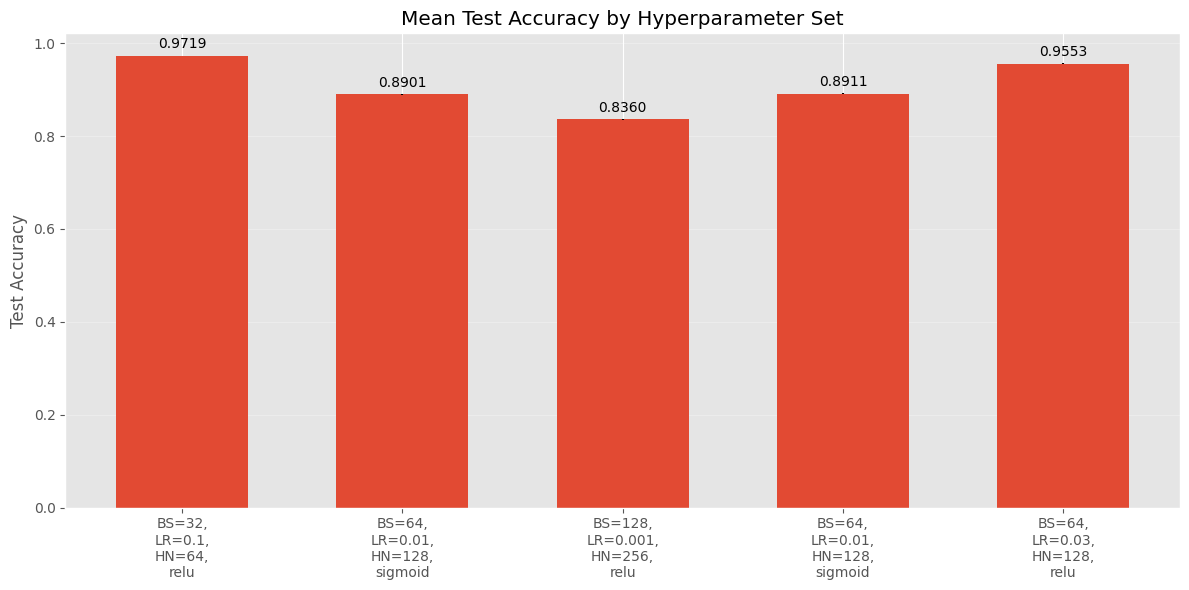

In [ ]:
# Bar chart comparing mean accuracies
plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.6

# Create bar labels with hyperparameter details
labels = [
    f"BS={r['hyperparams']['batch_size']},\nLR={r['hyperparams']['learning_rate']},\n" +
    f"HN={r['hyperparams']['hidden_neurons']},\n{r['hyperparams']['activation']}"
    for r in results
]

bars = plt.bar(x, [r['mean_accuracy'] for r in results], width, yerr=[r['std_accuracy'] for r in results])

plt.ylabel('Test Accuracy')
plt.title('Mean Test Accuracy by Hyperparameter Set')
plt.xticks(x, labels)
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f"{results[i]['mean_accuracy']:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()